In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import tools as tl

# Read the CSV files
data1_cd4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
df = data1_cd4[["MT-CO1", "MT-CO2"]]
# Data
observed_X = np.array(df[["MT-CO1"]])
observed_Y = np.array(df[["MT-CO2"]])

In [5]:
index =observed_X !=0
observed_X[index]

array([23, 24, 16, ..., 10, 36,  9])

In [ ]:
n_iter = 10000
burn_in = 5000
name_0 = 'MT-ND6'
def metropolis_hastings(data,pre_para,n_iter=10000, burn_in=2000, thin=5):
    sigma_mu = pre_para[0]
    sigma_r = pre_para[1]
    sigma_psi = pre_para[2]
    trace = np.zeros((n_iter, 3))  # ordered mu, r, psi
    trace[0, :] = np.array([5., 1.,0.4])
    acceptance_rate = np.zeros(n_iter)
    mu = trace[0, 0]

    for i in range(1, n_iter):
        theta = trace[i-1, :]  # theta = (mu, r, psi)

        theta_p = np.array([np.random.normal(theta[0], sigma_mu),
                            truncnorm_prop_r(theta[1], sigma_r),
                            truncnorm_prop_psi(theta[2], sigma_psi)])
        mu_p = theta_p[0]
        if mu <= 0:
            print("mu == 0 on iteration %d" % i)

        alpha = nb_acceptance_ratio((mu, theta[1],theta[2]),
                                    (mu_p, theta_p[1],theta_p[2]), data)
        u = np.log(np.random.uniform(0., 1.))

        if u < alpha:
            trace[i, :] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i, :] = theta
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin, :])
trace =metropolis_hastings(data_norm[name_0],[0.5,0.5,0.001],n_iter, burn_in)

Acceptance rate: 0.14


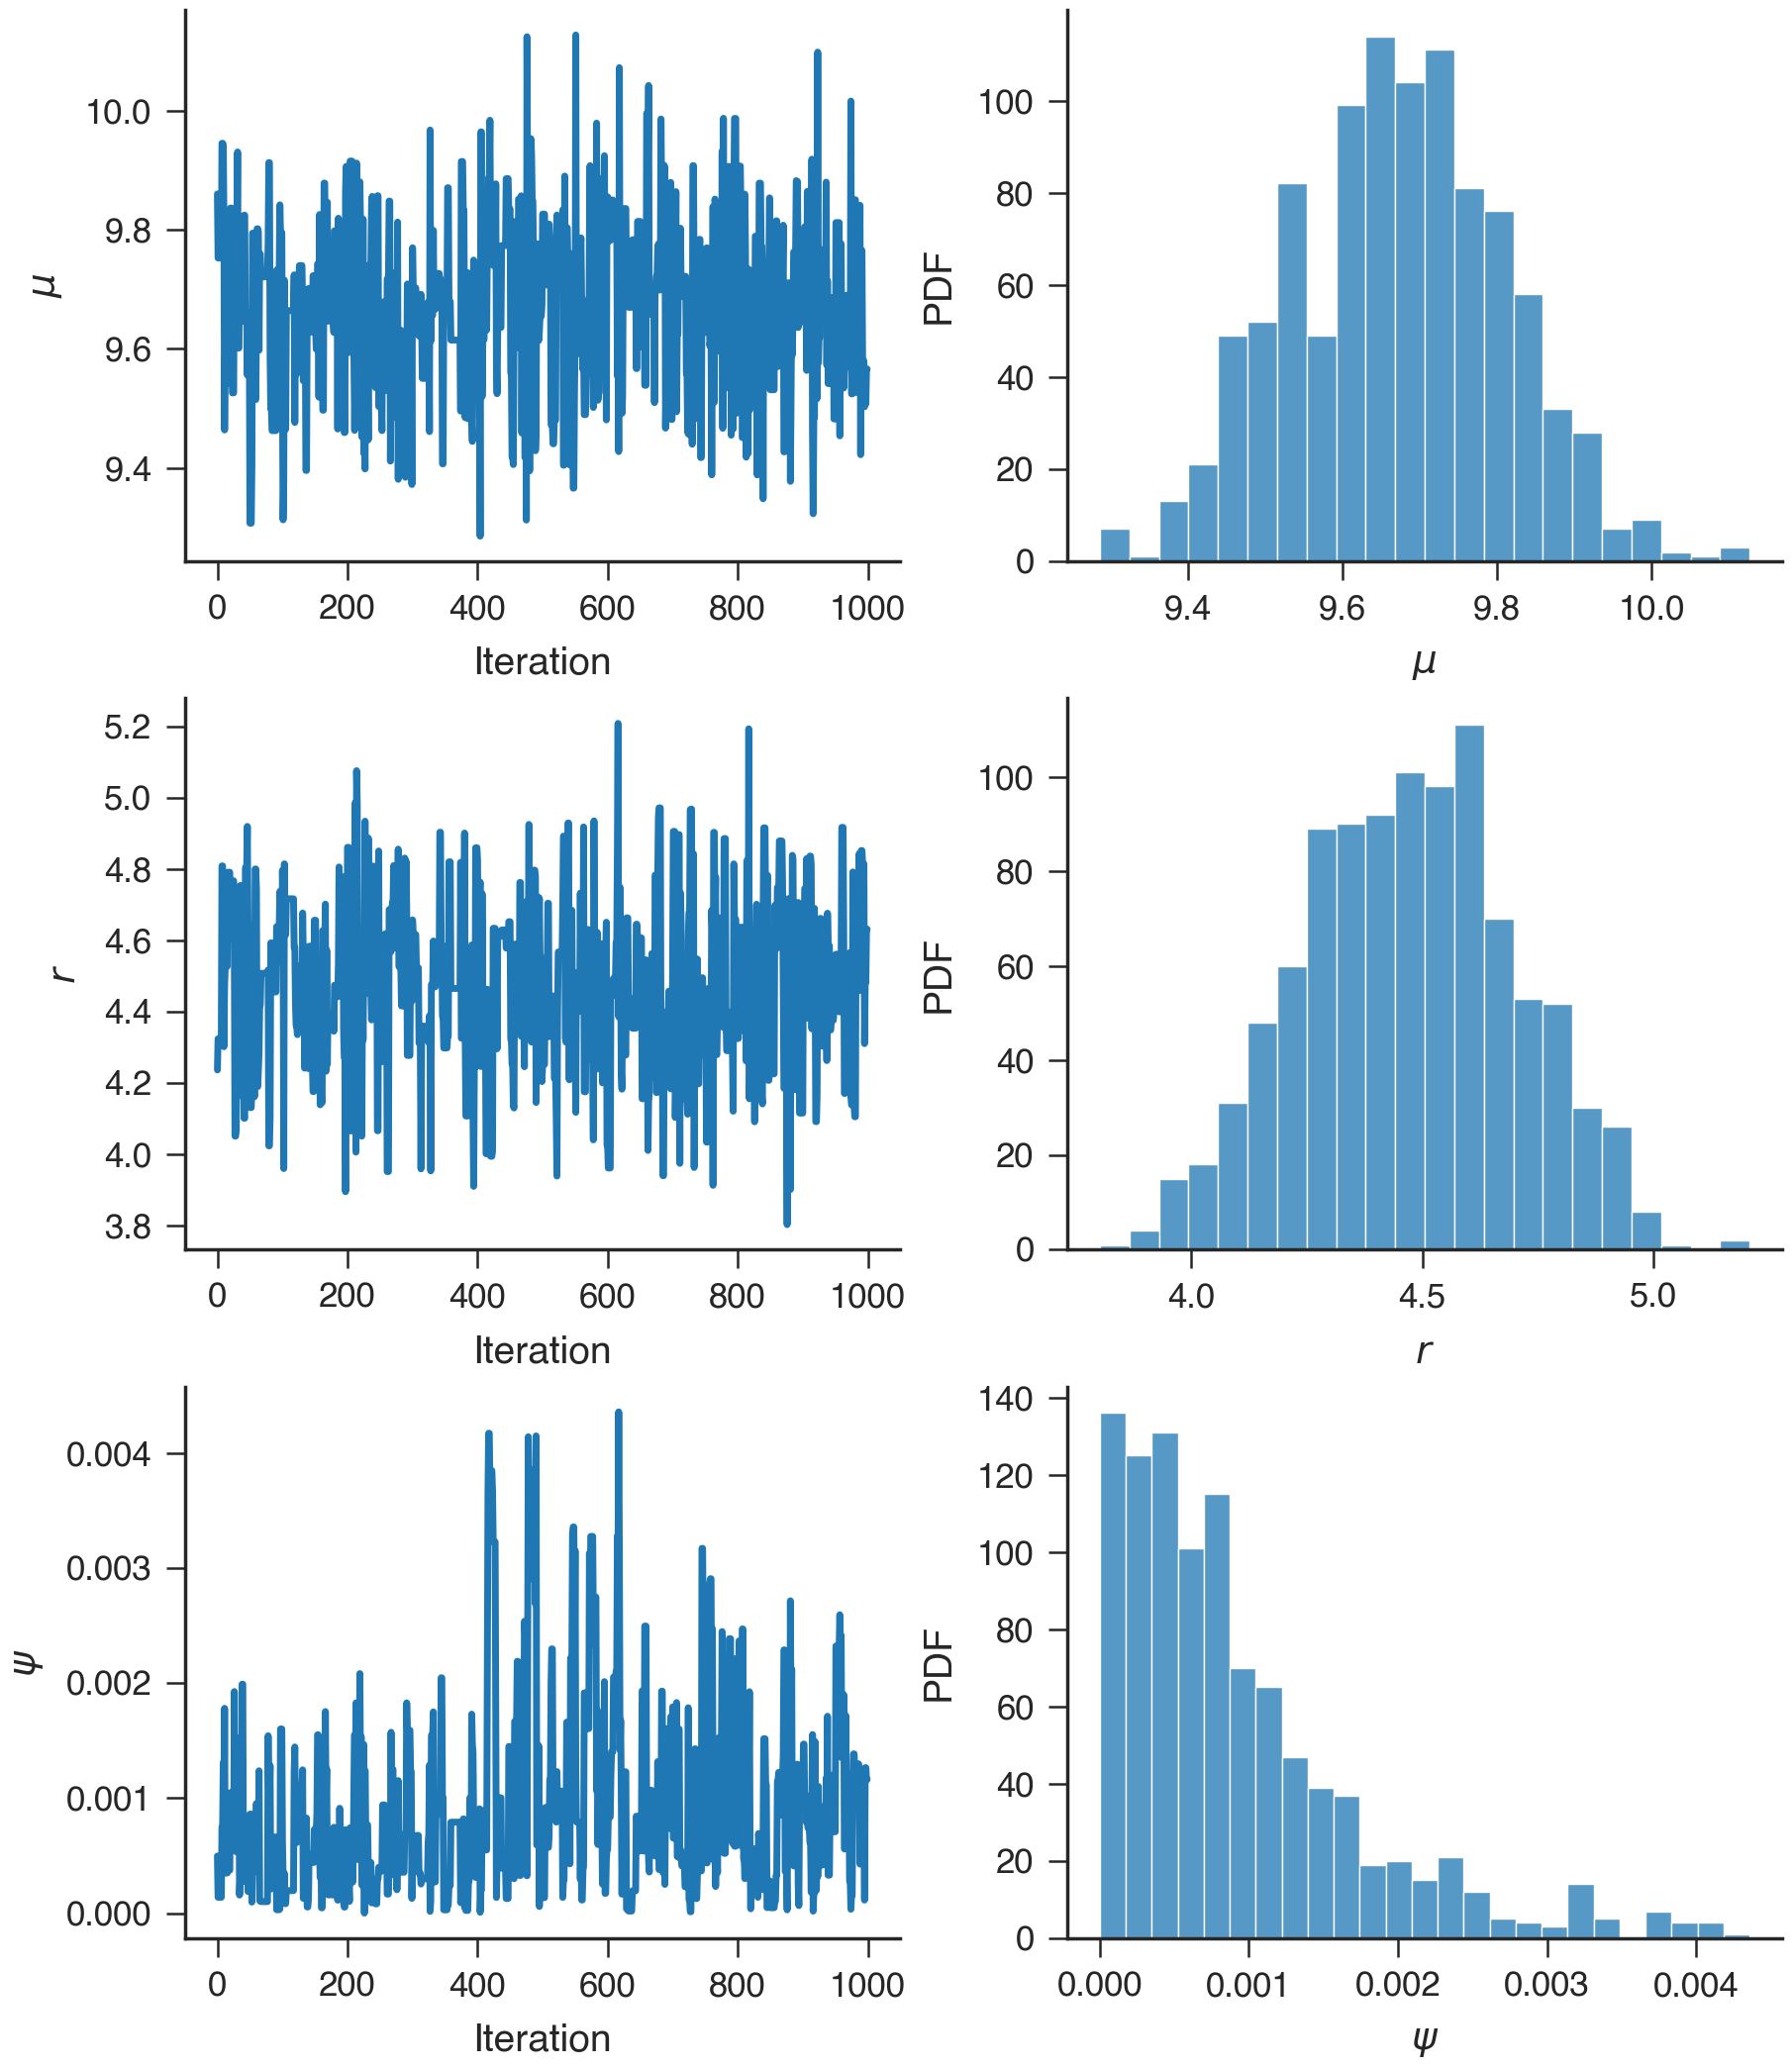

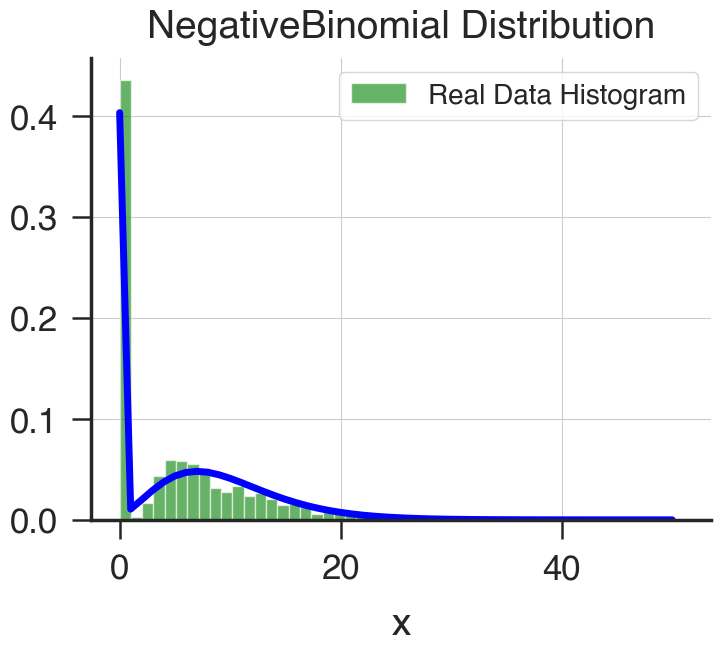

In [ ]:
import statsmodels as smd
trace=pd.DataFrame(trace[:])
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
p = 1 - trace[0] / (trace[1] + trace[0])
labels=[r'$\mu$',r'$r$',r'$\psi$']
count=0
ax=axs.flatten()[0]
ax.plot(trace[0])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[0])

ax=axs.flatten()[1]
sns.histplot(trace[0],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[0])

ax=axs.flatten()[2]
ax.plot(trace[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[1])

ax=axs.flatten()[3]
sns.histplot(trace[1],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[1])
f.tight_layout()

ax=axs.flatten()[4]
ax.plot(trace[2])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[2])

ax=axs.flatten()[5]
sns.histplot(trace[2],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[2])
f.tight_layout()

col_means = [0,0]
col_means[0] = trace[0].mean()
col_means[1] = trace[1].mean()
col_means[2] = trace[2].mean()
# Compute the Gamma distribution PDF values
x = np.array(range(0,round(data_norm[name_0].max())))
# x = np.array(range(0,60))
pmf = [zinb_pmf(i, col_means[0], col_means[1], 0.4) for i in x]
# pmf = [stats.nbinom.pmf(i, n=9.335, p=0.036) for i in x]

# Plot the Gamma distribution
plt.figure(figsize=(8, 6))
plt.plot(x, pmf,  color='b')

plt.hist(data_norm[name_0],  bins=50,density=True, alpha=0.6, color='g', label='Real Data Histogram')

plt.title('NegativeBinomial Distribution')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()


IndexError: list index out of range

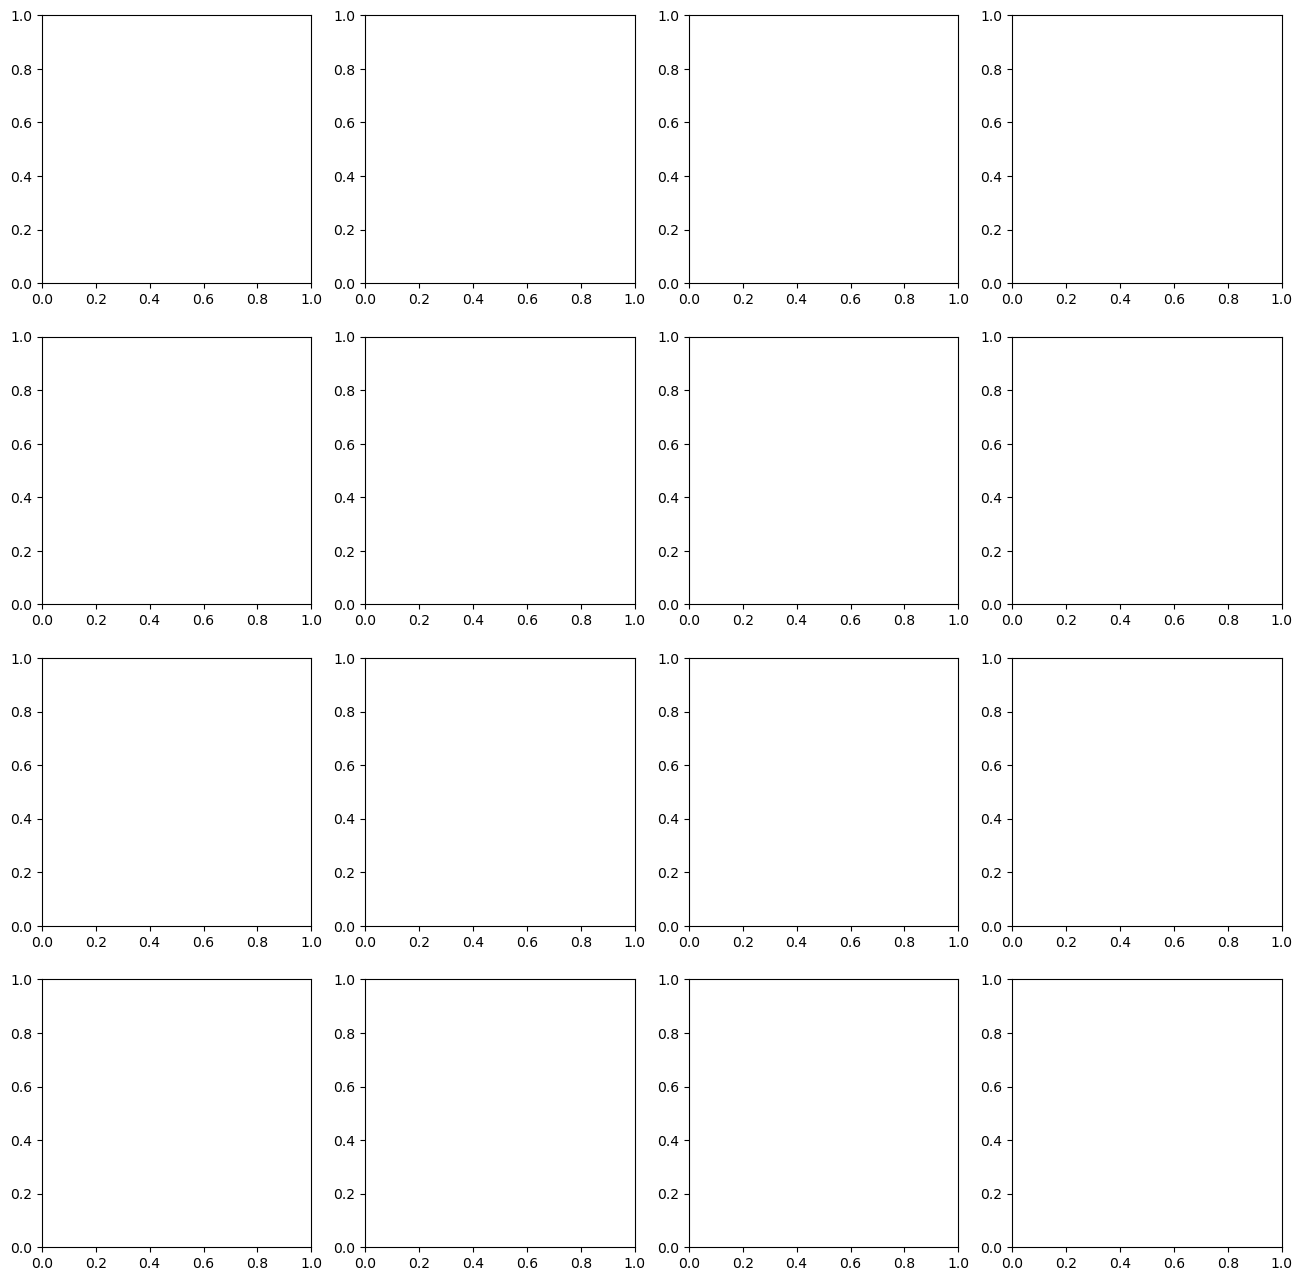

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate some example data for demonstration
# Replace this with your actual data
data1_cd4 = {f'MT-CO{i}': np.random.negative_binomial(n=5, p=0.5, size=1000) for i in range(1, 14)}

# Define parameters for the Negative Binomial distribution
col_means = [(5, 0.5)] * 13  # Example parameters; replace with your actual parameters

x = np.arange(0, 100)  # Range for x values

# Set up the plotting environment
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, (key, data) in enumerate(data1_cd4.items()):
    # Compute the Negative Binomial distribution PDF values
    pmf = [stats.nbinom.pmf(i, n=col_means[i][0], p=col_means[i][1]) for i in x]
    
    # Plot the Negative Binomial distribution
    axes[i].plot(x, pmf, color='b', label='Negative Binomial PDF')
    axes[i].hist(data, bins=50, density=True, alpha=0.6, color='g', label='Real Data Histogram')
    
    # Set titles and labels
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [23]:
import tools

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Correlation calculated using copula: 0.5468407909719678
            X          Y
0    4.208229  14.279872
1    3.426124  32.877291
2    7.545920   7.724850
3   10.764697  19.276305
4   16.484344  34.659281
..        ...        ...
95  29.069520  51.275826
96  23.149513  24.286187
97  13.904361  23.726457
98   8.615584  26.669055
99   0.296548  15.001175

[100 rows x 2 columns]


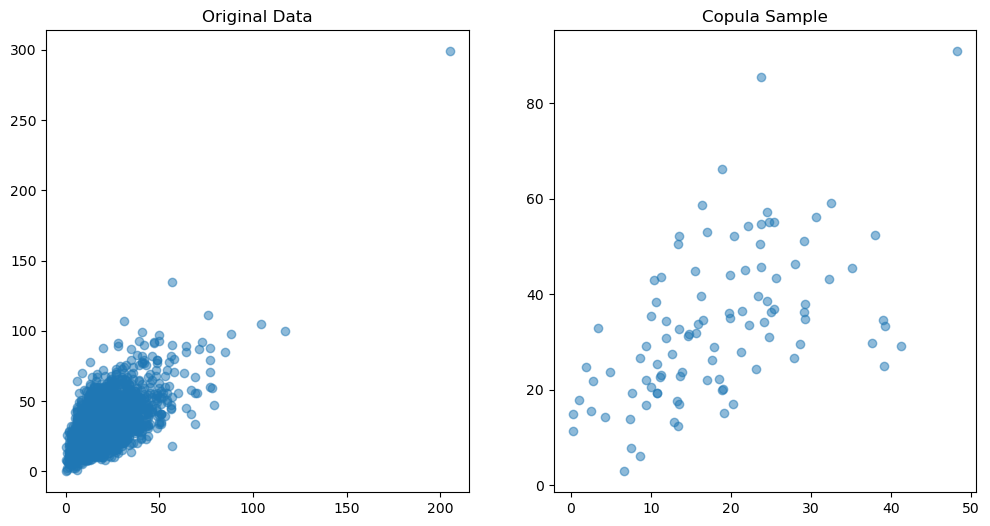

In [21]:

from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d

# 生成示例数据
np.random.seed(0)
n = 100
data = pd.DataFrame({
    'X': np.array(df[["MT-CO1"]]).reshape(-1),
    'Y': np.array(df[["MT-CO2"]]).reshape(-1)
})

# 创建并训练Gaussian Copula模型
copula = GaussianMultivariate()
copula.fit(data)

# 计算伪观测值（copula估计值）
pseudo_obs = copula.sample(n)

# 计算相关系数
correlation = pseudo_obs.corr().iloc[0, 1]

print(f'Correlation calculated using copula: {correlation}')

# 可视化数据和copula生成的样本
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data['X'], data['Y'], alpha=0.5)
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.scatter(pseudo_obs['X'], pseudo_obs['Y'],alpha=0.5)
plt.title('Copula Sample')

print(pseudo_obs)
plt.show()


In [2]:
with pm.Model() as model:
    # Priors for the model parameters
    r = pm.Gamma('r', alpha=df['e_0'], beta=df['h'], shape=J)

    alpha = pm.Gamma('alpha', alpha=df['e_0'], beta=df['f_0'], shape=2)
    gamma = pm.Gamma('gamma', alpha=df['e_0'], beta=df['f_0'], shape=K)
    h = pm.Gamma('h', alpha=df['e_0'], beta=df['f_0'])

    # Initialize beta
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(1/alpha), shape=2)
    
    # Initialize Phi and theta
    Phi = pm.MvNormal('Phi', mu=np.zeros(V), cov=np.eye(2), shape=(2, 2))
    theta = pm.Normal('theta', mu=0, sigma=np.sqrt(1/gamma), shape=(J, 2))

    # Logistic function for p
    phi = pm.Deterministic('phi', np.dot(df['x'], beta.T) + np.dot(theta, Phi.T))
    p = pm.Deterministic('p', pm.math.sigmoid(phi))
    
    # Priors for the negative binomial parameters
    r_X = pm.Gamma('r_X', alpha=1.0, beta=1.0)
    r_Y = pm.Gamma('r_Y', alpha=1.0, beta=1.0)
    
    
    # Gaussian copula parameters
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    
    # Copula latent variables
    u = pm.Normal('u', mu=0, sigma=1, shape=(2, len(observed_X)))
    copula_X = pm.Deterministic('copula_X', pm.math.invprobit(u[0, :]))
    copula_Y = pm.Deterministic('copula_Y', pm.math.invprobit(u[1, :]))

    # Negative Binomial likelihood
    X = pm.NegativeBinomial('X', mu=r_X * (1 - p_X) / p_X, alpha=r_X, observed=observed_X)
    Y = pm.NegativeBinomial('Y', mu=r_Y * (1 - p_Y) / p_Y, alpha=r_Y, observed=observed_Y)
    
    # Define a custom likelihood using the copula
    def bivariate_nb_likelihood(X, Y, r_X, p_X, r_Y, p_Y, corr):
        copula_X = pm.math.invprobit(X)
        copula_Y = pm.math.invprobit(Y)
        
        # Copula log likelihood
        copula_ll = (
            -0.5 * np.log(1 - corr[0, 1] ** 2)
            - 0.5 * (copula_X ** 2 + copula_Y ** 2 - 2 * corr[0, 1] * copula_X * copula_Y) / (1 - corr[0, 1] ** 2)
        )
        
        # Marginal Negative Binomial log likelihoods
        
        nb_X_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_X * (1 - p_X) / p_X, alpha=r_X), r_X).sum().eval()
        nb_Y_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_Y * (1 - p_Y) / p_Y, alpha=r_Y), r_Y).sum().eval()
        
        return copula_ll + nb_X_ll + nb_Y_ll

    # Custom likelihood
    pm.Potential('likelihood', bivariate_nb_likelihood(X, Y, r_X, p_X, r_Y, p_Y, corr))

    # Inference
    trace = pm.sample(20, tune=10, cores=2)

# Summary
pm.summary(trace)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_X, p_X, r_Y, p_Y, chol, u]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 11 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chol[0],0.866,1.013,0.017,2.794,0.150,0.106,22.0,23.0,1.04
chol[1],1.009,0.657,0.300,2.338,0.160,0.115,16.0,50.0,1.11
chol[2],0.015,0.010,0.005,0.035,0.002,0.002,16.0,50.0,1.11
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,40.0,40.0,NaN
"chol_corr[0, 1]",1.000,0.000,1.000,1.000,0.000,0.000,16.0,22.0,1.11
...,...,...,...,...,...,...,...,...,...
"u[1, 2883]",0.000,0.993,-1.587,1.359,0.150,0.110,47.0,57.0,1.00
"u[1, 2884]",-0.021,0.832,-1.261,1.194,0.151,0.155,32.0,51.0,1.13
"u[1, 2885]",-0.014,1.236,-2.267,1.877,0.154,0.151,64.0,50.0,1.02
"u[1, 2886]",0.010,0.968,-1.246,1.580,0.121,0.124,64.0,23.0,1.01


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_wid

OverflowError: cannot convert float infinity to integer

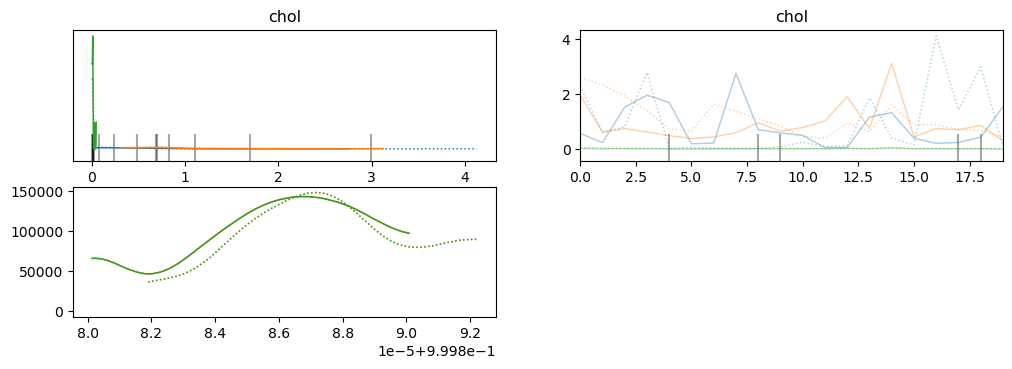

In [4]:
import matplotlib.pyplot as plt


# Plot trace of the samples
pm.plot_trace(trace)
plt.show()


In [7]:
import arviz as az
idata=pm.sample()
# Convert the trace to an ArviZ InferenceData object
az.plot_pair(idata, var_names=['r_X', 'p_X', 'r_Y', 'p_Y'], kind='kde')
plt.show()

TypeError: No model on context stack.

In [8]:
gamma = np.array([1.0, 4.0, 9.0, 16.0])  # Example vector

# Calculate the expression element-wise
result = 1 / np.sqrt(gamma)
print(result)

[1.         0.5        0.33333333 0.25      ]


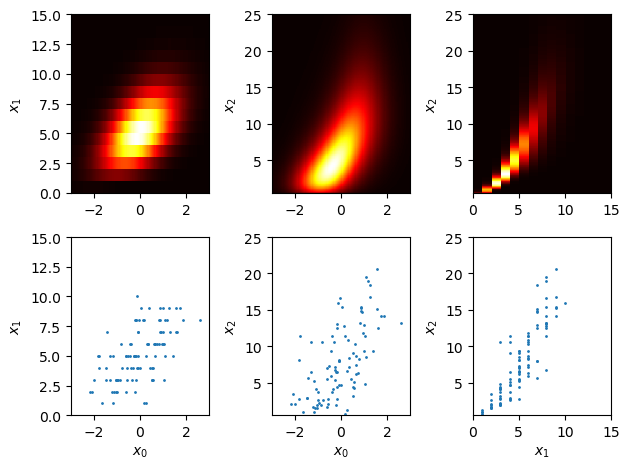

In [6]:
from scipy.stats import norm, gamma, poisson
import numpy as np
from mixedvines.copula import Copula, GaussianCopula, ClaytonCopula, \
        FrankCopula
from mixedvines.mixedvine import MixedVine
import matplotlib.pyplot as plt
import itertools
# Manually construct mixed vine
dim = 3  # Dimension
vine = MixedVine(dim)
# Specify marginals
vine.set_marginal(0, norm(0, 1))
vine.set_marginal(1, poisson(5))
vine.set_marginal(2, gamma(2, 0, 4))
# Specify pair-copulas
vine.set_copula(1, 0, GaussianCopula(0.5))
vine.set_copula(1, 1, FrankCopula(4))
vine.set_copula(2, 0, ClaytonCopula(5))
# Calculate probability density function on lattice
bnds = np.empty((3), dtype=object)
bnds[0] = [-3, 3]
bnds[1] = [0, 15]
bnds[2] = [0.5, 25]
x0, x1, x2 = np.mgrid[bnds[0][0]:bnds[0][1]:0.05, bnds[1][0]:bnds[1][1],
                      bnds[2][0]:bnds[2][1]:0.1]
points = np.array([x0.ravel(), x1.ravel(), x2.ravel()]).T
pdf = vine.pdf(points)
pdf = np.reshape(pdf, x1.shape)
# Generate random variates
size = 100
samples = vine.rvs(size)
# Visualize 2d marginals and samples
comb = list(itertools.combinations(range(dim), 2))
for i, cmb in enumerate(comb):
    # Sum over all axes not in cmb
    cmb_inv = tuple(set(range(dim)) - set(cmb))
    margin = np.sum(pdf, axis=cmb_inv).T
    plt.subplot(2, len(comb), i + 1)
    plt.imshow(margin, aspect='auto', interpolation='none', cmap='hot',
               origin='lower', extent=[bnds[cmb[0]][0], bnds[cmb[0]][1],
                                       bnds[cmb[1]][0], bnds[cmb[1]][1]])
    plt.ylabel('$x_' + str(cmb[1]) + '$')
    plt.subplot(2, len(comb), len(comb) + i + 1)
    plt.scatter(samples[:, cmb[0]], samples[:, cmb[1]], s=1)
    plt.xlim(bnds[cmb[0]][0], bnds[cmb[0]][1])
    plt.ylim(bnds[cmb[1]][0], bnds[cmb[1]][1])
    plt.xlabel('$x_' + str(cmb[0]) + '$')
    plt.ylabel('$x_' + str(cmb[1]) + '$')
plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import truncnorm, poisson, norm, nbinom, multivariate_normal
import scipy.stats as stats
stats.nbinom.cdf(0,4,0.5)

0.0625